# Using GloVe

DS 5001 Text as Data

**Purpose:** We use some pretrained word vectors from [the developers of GloVe](https://nlp.stanford.edu/projects/glove/).

# About GloVe

> Unlike the matrix factorization methods, the shallow window-based methods [e.g. word2vec] suffer \
> from the disadvantage that **they do not operate directly on the co-occurrence statistics of the corpus.** \
> Instead, these models scan context windows across the entire corpus, which fails to take advantage of the \
> vast amount of repetition in the data.

# Set Up

In [9]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [10]:
data_in = f'{data_home}/glove'
# db_file = f'{data_in}/glove2.db'

In [11]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity

# Import GloVe data

We import a word embedding with 400,000 token types and 50. 100, 200, or 300 features.

In [20]:
!ls {data_home}/glove/*

/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove2.db
/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove.6B.100d.txt
/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove.6B.200d.txt
/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove.6B.300d.txt
/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove.6B.50d.txt
/sfs/gpfs/tardis/home/rca2t/Documents/MSDS/DS5001/DS5001-2025-01-R/data/glove/glove.6B.zip


In [21]:
n_features = 100 # 50, 100, 200, 300

In [24]:
glove = pd.read_csv(f"{data_home}/glove/glove.6B/glove.6B.{n_features}d.txt", sep="\s", header=None, engine='python')
glove = glove.set_index(0)
glove.index.name = 'term_str'
glove = glove.astype(float)

In [25]:
glove.shape

(400000, 100)

In [28]:
glove.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
term_str,,,,,,,,,,,,,,,,,,,,,
berberian,0.412290,-0.031605,-0.484090,-0.10598,-0.211740,-0.069262,-0.050821,-0.102880,0.23726,0.141430,...,0.051952,-0.18222,0.363280,-0.190440,0.069427,-0.014373,-0.378890,0.416000,-0.586520,0.087628
αβ,0.043244,0.121670,-0.222350,0.23346,-0.341970,0.333390,0.384030,0.077151,-0.11014,-0.205210,...,-0.256030,0.33161,0.101490,-0.584970,0.663360,-0.441860,-0.261670,0.005268,-0.544540,0.187140
acyf,0.721840,0.449110,0.109350,-0.68499,-0.394660,0.113070,-0.702940,0.516680,-0.23274,-0.713210,...,0.068836,0.04929,-0.328470,0.173610,0.195270,-0.084224,-0.589020,-0.223170,-0.294460,-0.419580
winden,0.182220,-0.551560,-0.646480,0.31625,-0.310140,-0.266470,0.040597,-0.390620,0.54291,-0.306140,...,-0.158150,0.43602,0.547040,0.007306,0.594210,0.287780,-0.131080,0.619140,-0.187480,-0.123340
spaetzle,-0.225940,0.525080,0.136600,0.27099,-0.044491,-0.181050,0.435230,-0.092177,0.52602,-0.289980,...,0.109560,0.26242,-0.070243,-0.604250,0.582780,-0.535210,0.509460,0.232610,-0.015539,-0.312980
friendships,0.613590,0.464390,-0.621000,0.46387,-0.083247,0.144440,-0.093331,-0.890220,-0.13817,-0.072856,...,-0.481420,0.47193,0.270740,-0.093603,0.095998,-0.171020,-0.393910,-0.450110,-0.076216,0.986150
nonrefundable,0.348410,0.232560,-0.078994,0.51194,0.402180,-0.073183,0.162630,0.787980,-0.15888,0.249960,...,-1.244400,0.27554,0.411940,-0.604060,-0.114980,-0.169150,0.284160,0.630830,0.165850,-0.267440
tibisay,-0.056782,-0.791540,0.132730,0.17857,0.058030,-0.060759,-0.276760,0.296910,0.10358,-0.906030,...,0.290970,0.39537,-0.701470,0.520900,0.070837,0.299140,0.374370,0.179400,-0.682230,-0.318530
vodnik,0.339690,0.097682,-0.234660,0.54116,0.257430,-0.165770,0.408670,0.026357,0.14612,-0.234790,...,0.179160,-0.09464,0.257830,-0.306820,-0.027774,0.196110,0.092745,0.158400,-0.705530,0.049599


# Explore Features

In [29]:
test_sentence = sorted(list(set("the quick brown fox jumped over the lazy dogs".split())))

In [30]:
glove.loc[test_sentence].T.sample(10).T\
    .style.format(precision=2).background_gradient(cmap='YlGnBu', axis=None)

,44,57,58,93,9,27,49,1,28,2
term_str,,,,,,,,,,
brown,0.06,-0.11,0.28,-0.43,-0.59,0.16,0.45,-0.44,-0.43,-0.10
dogs,-0.72,0.15,-0.10,0.53,-0.39,-0.92,0.18,0.38,-0.36,0.30
fox,0.81,-0.33,0.20,0.20,-0.43,0.41,0.26,0.17,0.46,-1.00
jumped,-0.31,-0.52,0.33,-0.33,0.14,-0.45,0.51,1.63,0.09,0.37
lazy,0.04,0.50,0.30,-0.20,-0.37,-0.97,0.36,0.14,-0.02,-0.20
over,-0.32,-0.00,-0.23,-0.99,-0.49,0.17,0.13,-0.30,-0.01,0.35
quick,-0.89,-0.01,0.15,-0.41,-0.29,-0.64,0.65,-0.43,0.29,-0.22
the,-0.13,0.01,-0.37,-0.39,-0.58,0.03,-0.37,-0.04,-0.54,-0.24


In [31]:
FEATURE = glove.mean().to_frame('mean_weight')
FEATURE['max_weight'] = glove.max()
FEATURE['min_weight'] = glove.min()
FEATURE['max_word'] = glove.idxmax()
FEATURE['min_word'] = glove.idxmin()

In [32]:
# FEATURE.sample(10)

# Are embedding features like topics?

In [33]:
FEATURE['top_words'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [34]:
FEATURE.sort_values('mean_weight', ascending=False).head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words
56,0.464231,2.4311,-3.6792,sayn,a,sayn microns djordje azarias djukic republish ...
85,0.294030,2.6886,-3.0816,chernykh,patients,chernykh 147.27 warmian-masurian elhanan icasu...
79,0.275634,2.5450,-2.3225,saute,smithee,"saute 0-40 right-arm 10,000-point mixer unsalt..."
95,0.208303,2.6155,-2.1484,ergenekon,lufkin,ergenekon 78-day bulbophyllum sql racketeering...
74,0.196464,2.9406,-2.7764,herein,sfgate.com,herein 79.75 greco-roman lxii highest-rated vi...
50,0.194247,2.2537,-2.7613,abilio,resend,abilio novaya ouvrage zille andry tassos kennet
28,0.194193,2.4583,-2.4019,cosmodrome,shuh,cosmodrome multiplexed xichang plesetsk detona...
42,0.186347,2.5956,-2.8971,zabihullah,tablespoons,zabihullah ayp hizbul foday shamil bhasa asom
41,0.162822,2.9100,-2.2892,estádio,gambari,estádio 225-issue ilich goals-against d'epargn...
48,0.156756,2.6423,-3.2878,passerine,republish,passerine verbandsgemeinde carbonyl birla cred...


# Remove non-words

There are a lot of useless tokens in the vocabulary. These may be good for generating the features, but we don't need them in our queries.

In [35]:
glove = glove.loc[glove.index.dropna()]

In [36]:
# glove

In [37]:
# glove = glove.reset_index().astype(str)
# glove = glove[glove.term_str.str.match(r'^[a-z]+$')]
# glove = glove.set_index('term_str')
glove = glove[glove.index.str.match(r'^[a-z]+$')]

In [38]:
glove = glove.astype(float)
glove.shape

(317754, 100)

In [39]:
# glove.index.value_counts()

In [40]:
FEATURE['top_words2'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [41]:
FEATURE.head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words,top_words2
1,0.052098,2.4396,-4.0666,bovespa,republish,bovespa 225-issue cac-40 balco knowingly zetas...,bovespa balco knowingly zetas ordinaries sugar...
2,-0.097114,2.5180,-2.3313,distillates,zhongshu,distillates distillate outnumbering expander 2...,distillates distillate outnumbering expander w...
3,-0.138076,2.6546,-2.2963,aonb,right-arm,aonb radomsko keyless text-type (310) update2 ...,aonb radomsko keyless kgalema voivodeship noct...
4,0.110753,3.2142,-2.4469,non-mandatory,porpoises,non-mandatory jonubi certiorari algebraic norm...,jonubi certiorari algebraic normalising barvik...
5,-0.027228,2.7884,-2.4436,baronetage,statesman.com,baronetage longlisted worldsources ayman olyā ...,baronetage longlisted worldsources ayman mcca ...
6,-0.003264,2.5575,-2.6252,c/d,petroleum,c/d 33-1-47-42-80-44 lycaenidae chanting canon...,lycaenidae chanting canons mobs catholic chant...
7,0.031764,2.2657,-2.4128,g6,sensex,g6 undervotes glafcos agusta lancer yearling s...,undervotes glafcos agusta lancer yearling span...
8,-0.050769,2.2472,-2.4823,weekdays,jacobite,weekdays saturdays vidhan canvassing panamá fi...,weekdays saturdays vidhan canvassing fille com...
9,0.153216,2.7588,-2.7738,otros,unbeaten,otros paises tambien estan (816) castile-la jaane,otros paises tambien estan jaane latinoamerica...
10,-0.023674,2.3914,-2.2391,hossein,uk-apc,hossein bushehr leed plesetsk warhead vung gan...,hossein bushehr leed plesetsk warhead vung gan...


# Define some semantic functions

In [42]:
def get_word_vector(term_str):
    """Get a numpy array from the glove matrix and shape for input into cosine function"""
    wv = glove.loc[term_str].values.reshape(-1, 1).T
    return wv

def get_sims(term_str, n=10):
    """Get the top n words for a given word based on cosine similarity"""
    wv = get_word_vector(term_str)
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(n)

def get_nearest_vector(wv):
    """Get the nearest word vector to a given word vector"""
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(2).iloc[1]

def get_difference(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.subtract(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_sum(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.add(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_analogy(a, b, c):
    """Infer missing analogical term"""
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = get_word_vector(c)
        D = np.add(np.subtract(B, A), C)
        X = get_nearest_vector(D)
        return X.name
    except ValueError as e:
        print(e)
        return None

# Test similarity function

In [43]:
get_sims('queen')

,score
term_str,
queen,1.000000
princess,0.794724
king,0.750769
elizabeth,0.735571
royal,0.706503
lady,0.704480
victoria,0.685376
monarch,0.668326
crown,0.668056


In [44]:
get_sims('king')

,score
term_str,
king,1.000000
prince,0.768233
queen,0.750769
son,0.702089
brother,0.698578
monarch,0.697789
throne,0.691999
kingdom,0.681141
father,0.680203


In [45]:
get_sims('milk')

,score
term_str,
milk,1.000000
dairy,0.761276
meat,0.748176
sugar,0.734551
yogurt,0.695376
juice,0.694653
cream,0.685067
egg,0.683237
soda,0.676703


In [46]:
get_sims('beer')

,score
term_str,
beer,1.000000
drink,0.818214
drinks,0.798284
liquor,0.732116
coffee,0.725339
vodka,0.724695
wine,0.724451
bottle,0.717643
beers,0.699328


# Test difference function

In [47]:
get_difference('man', 'woman')

'ancelotti'

In [48]:
get_sims('ancelotti')

,score
term_str,
ancelotti,1.000000
ranieri,0.822743
mourinho,0.820027
capello,0.736949
houllier,0.719588
mancini,0.713135
wenger,0.710990
scolari,0.690986
lippi,0.687543


In [49]:
get_difference('woman', 'man')

'miscarry'

In [50]:
get_sims('miscarry')

,score
term_str,
miscarry,1.000000
ovulate,0.628454
breastfeed,0.617344
menstruate,0.600057
miscarried,0.588849
mortify,0.582306
vocalize,0.580238
gestate,0.563410
ovulating,0.562108


In [51]:
get_difference('human', 'culture')

'nonhuman'

In [52]:
get_sims('nonhuman')

,score
term_str,
nonhuman,1.000000
primates,0.697258
habitations,0.623479
fallible,0.617184
beings,0.576165
apes,0.558138
anthropomorphic,0.552706
strepsirrhine,0.545927
vertebrates,0.538547


In [53]:
get_difference('man', 'human')

'fireman'

In [54]:
get_sims('fireman')

,score
term_str,
fireman,1.000000
firefighter,0.717793
paramedic,0.574579
mechanic,0.564724
rescuer,0.551241
chauffeur,0.542937
welder,0.542476
watchman,0.522622
janitor,0.515656


In [55]:
get_difference('human', 'man')

'reproductive'

In [56]:
get_difference('woman', 'human')

'schoolteacher'

In [57]:
get_difference('human', 'woman')

'mechanisms'

In [58]:
get_difference('christianity', 'jesus')

'protestantism'

In [59]:
get_sum('protestantism', 'pope')

'catholicism'

In [60]:
get_sims('protestantism')

,score
term_str,
protestantism,1.000000
catholicism,0.913007
christianity,0.811677
lutheranism,0.800469
calvinism,0.749115
anglicanism,0.729683
orthodoxy,0.673827
methodism,0.672810
hinduism,0.663173


# Test analogy function

## MALE / FEMALE

In [61]:
get_analogy('dog', 'male', 'cat')

'female'

In [62]:
get_analogy('male', 'doctor', 'female')

'nurse'

In [63]:
get_analogy('king', 'queen', 'male')

'female'

In [64]:
get_analogy('king', 'male', 'queen')

'female'

In [65]:
get_analogy('queen', 'female', 'king')

'male'

In [66]:
get_analogy('female', 'princess', 'male')

'queen'

In [67]:
get_analogy('male', 'prince', 'female')

'king'

In [68]:
get_analogy('male', 'father', 'female')

'brother'

In [69]:
get_analogy('female', 'mother', 'male')

'daughter'

In [70]:
get_analogy('woman', 'mother', 'man')

'brother'

In [71]:
get_analogy('woman', 'man', 'female')

'male'

## LEFT / RIGHT

In [72]:
get_analogy('right', 'male', 'left')

'female'

In [73]:
get_analogy('right', 'left', 'male')

'female'

In [74]:
get_analogy('right', 'man', 'left')

'dead'

In [75]:
get_analogy('man', 'woman', 'right')

'woman'

In [76]:
get_analogy('left', 'right', 'white')

'black'

In [77]:
get_analogy('left', 'right', 'black')

'white'

In [78]:
get_analogy('woman', 'man', 'left')

'back'

## OTHER

In [79]:
get_analogy('sun','moon', 'male')

'female'

In [80]:
get_analogy('day', 'sun', 'night')

'sky'

# Experiment

Demonstrate how to project embeddings onto documents

In [210]:
LIB = pd.read_csv(f"{output_dir}/austen-melville-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f"{output_dir}/austen-melville-CORPUS.csv").set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num'])
CORPUS2 = CORPUS.copy().reset_index()\
    .merge(glove, on="term_str")\
    .set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num'])\
    .iloc[:, 5:]

In [212]:
CORPUS2.head()

1        2         3    \
book_id chap_id para_num sent_num token_num                               
105     1       1        0        0         -0.72078  0.20091 -0.048074   
                4        0        12        -0.72078  0.20091 -0.048074   
                5        0        87        -0.72078  0.20091 -0.048074   
                6        0        11        -0.72078  0.20091 -0.048074   
                7        0        8         -0.72078  0.20091 -0.048074   

                                                4        5        6    \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0          0.1269 -0.37153 -0.52941   
                4        0        12         0.1269 -0.37153 -0.52941   
                5        0        87         0.1269 -0.37153 -0.52941   
                6        0        11         0.1269 -0.37153 -0.52941   
                7        0        8          0.1269 -0.37153 -0.52941   

                                                 7         8      9       10   \
book_id chap_id para_num sent_num token_num                                     
105     1       1        0        0         -0.36062 -0.013027 -1.232 -1.0595   
                4        0        12        -0.36062 -0.013027 -1.232 -1.0595   
                5        0        87        -0.36062 -0.013027 -1.232 -1.0595   
                6        0        11        -0.36062 -0.013027 -1.232 -1.0595   
                7        0        8         -0.36062 -0.013027 -1.232 -1.0595   

                                             ...      91       92       93   \
book_id chap_id para_num sent_num token_num  ...                              
105     1       1        0        0          ...  0.16228 -0.51853  0.55819   
                4        0        12         ...  0.16228 -0.51853  0.55819   
                5        0        87         ...  0.16228 -0.51853  0.55819   
                6        0        11         ...  0.16228 -0.51853  0.55819   
                7        0        8          ...  0.16228 -0.51853  0.55819   

                                                 94       95       96   \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0          0.87975 -0.31328  0.41319   
                4        0        12         0.87975 -0.31328  0.41319   
                5        0        87         0.87975 -0.31328  0.41319   
                6        0        11         0.87975 -0.31328  0.41319   
                7        0        8          0.87975 -0.31328  0.41319   

                                                97       98       99      100  
book_id chap_id para_num sent_num token_num                                    
105     1       1        0        0          0.1363 -0.74303 -0.71248 -0.9654  
                4        0        12         0.1363 -0.74303 -0.71248 -0.9654  
                5        0        87         0.1363 -0.74303 -0.71248 -0.9654  
                6        0        11         0.1363 -0.74303 -0.71248 -0.9654  
                7        0        8          0.1363 -0.74303 -0.71248 -0.9654  

[5 rows x 100 columns]

## Sentence Embedding

In [215]:
SENT = CORPUS.groupby(['book_id','chap_id','para_num','sent_num']).term_str.apply(lambda x: ' '.join(map(str,x))).to_frame('sent_str').sort_index()

In [216]:
SENT.head()

sent_str
book_id chap_id para_num sent_num                                                   
105     1       1        0         sir walter elliot of kellynch hall in somerset...
                         1         this was the page at which the favourite volum...
                2        0                                   elliot of kellynch hall
                3        0         walter elliot born march 1 1760 married july 1...
                         1         of south park in the county of gloucester by w...

In [217]:
def get_sent_vector(sent_str):
    print(sent_str)
    sent_tokens = sent_str.lower().split()
    sv = glove.loc[sent_tokens].mean().values.reshape(-1,1).T
    return sv

def get_sent_sims(sent_str, n=10):
    sv = get_sent_vector(sent_str)
    sims = cosine_similarity(CORPUS2.values, sv)
    return pd.DataFrame(sims, index=CORPUS2.index, columns=['score'])\
        .sort_values('score', ascending=False).head(n).join(SENT)[['score','sent_str']].reset_index(drop=True)

In [218]:
test_sent = "She left the room"

In [219]:
get_sent_sims(test_sent)

She left the room


,score,sent_str
0,0.872496,all went well she did not dislike her own look...
1,0.872496,miss crawford had a claim and when it was no l...
2,0.872496,it had really occurred to her unprompted that ...
3,0.872496,mrs chapman had just reached the attic floor w...
4,0.872496,her uncle and both her aunts were in the drawi...
5,0.872496,the very gown you have been taking notice of i...
6,0.872496,sir thomas said no more but when they sat down...
7,0.872496,sir thomas said no more but when they sat down...
8,0.872496,the gentlemen joined them and soon after began...
9,0.872496,it was a cold but clear quiet and slantingly s...


## Book Embedding

In [221]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  
book_id chap_id para_num sent_num token_num            
105     1       1        0        0                NN  
                                  1                NN  
                                  2                NN  
                                  3                IN  
                                  4                NN  
...                                               ...  
34970   114     24       0        6                DT  
                                  7                NN  
                                  8                IN  
                                  9                NN  
                                  10               NN  

[2059272 rows x 5 columns]

In [224]:
BOOKS = CORPUS2.groupby('book_id').mean()

In [233]:
BOOKS.style.format(precision=2).background_gradient(cmap="YlGnBu", axis=0)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,-0.06,0.12,0.31,-0.19,-0.07,0.24,-0.13,0.18,-0.11,-0.02,0.07,0.08,0.27,0.06,0.13,-0.33,0.15,0.09,-0.43,0.22,0.22,-0.04,0.22,-0.04,0.22,-0.06,-0.17,-0.49,0.12,-0.14,-0.03,0.43,-0.00,0.07,-0.01,0.29,-0.00,0.25,-0.05,-0.13,-0.45,-0.19,0.20,-0.34,-0.07,0.01,0.24,-0.28,0.04,-0.71,0.04,-0.08,0.23,1.05,-0.22,-2.26,-0.04,-0.24,1.30,0.48,-0.09,0.75,-0.26,0.15,0.67,-0.08,0.49,0.33,0.11,-0.15,-0.03,-0.27,-0.05,-0.37,0.16,0.13,-0.15,-0.05,-0.81,-0.04,0.49,0.08,-0.37,0.16,-1.33,-0.28,0.07,-0.13,-0.19,-0.40,-0.07,-0.21,-0.04,0.15,-0.50,-0.02,-0.27,-0.29,0.37,0.18
121,-0.05,0.13,0.33,-0.19,-0.07,0.26,-0.14,0.20,-0.09,-0.02,0.08,0.08,0.26,0.05,0.12,-0.31,0.12,0.11,-0.41,0.20,0.21,-0.03,0.19,-0.04,0.24,-0.03,-0.17,-0.48,0.13,-0.14,-0.04,0.42,0.01,0.06,-0.01,0.29,0.01,0.25,-0.03,-0.14,-0.43,-0.19,0.18,-0.34,-0.09,-0.00,0.23,-0.27,0.03,-0.71,0.04,-0.08,0.23,1.04,-0.23,-2.26,-0.02,-0.21,1.33,0.46,-0.08,0.77,-0.26,0.14,0.67,-0.06,0.50,0.32,0.10,-0.16,-0.02,-0.26,-0.03,-0.36,0.16,0.14,-0.14,-0.07,-0.80,-0.05,0.49,0.07,-0.38,0.15,-1.33,-0.27,0.06,-0.12,-0.20,-0.38,-0.07,-0.19,-0.03,0.14,-0.49,-0.04,-0.26,-0.28,0.37,0.21
141,-0.06,0.13,0.32,-0.19,-0.07,0.24,-0.15,0.18,-0.09,-0.02,0.08,0.08,0.25,0.05,0.12,-0.32,0.14,0.11,-0.42,0.22,0.21,-0.04,0.20,-0.04,0.23,-0.03,-0.17,-0.50,0.13,-0.15,-0.05,0.45,0.01,0.07,-0.01,0.31,0.00,0.25,-0.04,-0.14,-0.44,-0.19,0.19,-0.35,-0.09,-0.00,0.24,-0.29,0.03,-0.72,0.03,-0.08,0.23,1.06,-0.22,-2.27,-0.01,-0.22,1.32,0.47,-0.08,0.76,-0.27,0.14,0.67,-0.07,0.50,0.33,0.11,-0.17,-0.02,-0.27,-0.04,-0.36,0.17,0.14,-0.15,-0.06,-0.81,-0.04,0.50,0.08,-0.39,0.15,-1.34,-0.28,0.07,-0.11,-0.20,-0.40,-0.07,-0.20,-0.04,0.14,-0.49,-0.04,-0.25,-0.29,0.38,0.20
158,-0.07,0.15,0.33,-0.21,-0.11,0.23,-0.14,0.20,-0.07,-0.04,0.08,0.08,0.27,0.05,0.12,-0.32,0.12,0.13,-0.43,0.25,0.21,-0.02,0.18,-0.07,0.22,-0.00,-0.18,-0.50,0.14,-0.14,-0.05,0.47,0.02,0.07,0.01,0.31,-0.00,0.25,-0.03,-0.16,-0.45,-0.18,0.19,-0.36,-0.11,-0.01,0.24,-0.28,0.02,-0.74,0.05,-0.09,0.24,1.03,-0.23,-2.26,-0.01,-0.19,1.31,0.46,-0.08,0.77,-0.30,0.11,0.70,-0.06,0.51,0.34,0.09,-0.17,-0.01,-0.27,-0.03,-0.36,0.17,0.13,-0.14,-0.07,-0.79,-0.05,0.49,0.05,-0.40,0.14,-1.35,-0.28,0.07,-0.11,-0.21,-0.40,-0.08,-0.20,-0.03,0.12,-0.48,-0.02,-0.25,-0.29,0.35,0.22
161,-0.05,0.12,0.32,-0.19,-0.08,0.25,-0.15,0.19,-0.08,-0.02,0.07,0.09,0.26,0.05,0.13,-0.32,0.13,0.10,-0.42,0.23,0.21,-0.05,0.19,-0.03,0.23,-0.02,-0.17,-0.50,0.14,-0.15,-0.03,0.44,0.01,0.07,-0.03,0.30,0.00,0.25,-0.04,-0.14,-0.44,-0.18,0.19,-0.34,-0.09,-0.01,0.23,-0.29,0.02,-0.72,0.04,-0.08,0.25,1.05,-0.22,-2.24,-0.01,-0.23,1.31,0.46,-0.07,0.76,-0.26,0.12,0.67,-0.07,0.50,0.33,0.12,-0.16,-0.02,-0.26,-0.04,-0.36,0.18,0.15,-0.15,-0.07,-0.81,-0.05,0.49,0.08,-0.38,0.15,-1.34,-0.28,0.07,-0.11,-0.21,-0.39,-0.08,-0.19,-0.02,0.15,-0.49,-0.04,-0.25,-0.29,0.37,0.20
946,-0.06,0.14,0.35,-0.18,-0.13,0.26,-0.17,0.18,-0.06,-0.03,0.08,0.10,0.26,0.05,0.11,-0.32,0.12,0.13,-0.44,0.28,0.18,-0.04,0.15,-0.05,0.22,0.03,-0.17,-0.52,0.19,-0.15,-0.03,0.47,0.04,0.07,-0.01,0.32,-0.01,0.24,-0.02,-0.16,-0.42,-0.17,0.19,-0.39,-0.14,-0.02,0.22,-0.29,0.01,-0.75,0.05,-0.06,0.23,1.03,-0.21,-2.22,0.03,-0.20,1.29,0.42,-0.06,0.76,-0.29,0.09,0.69,-0.04,0.50,0.35,0.09,-0.19,0.01,-0.26,-0.03,-0.37,0.18,0.15,-0.13,-0.06,-0.79,-0.06,0.47,0.07,-0.39,0.13,-1.34,-0.26,0.04,-0.12,-0.22,-0.42,-0.10,-0.18,0.01,0.13,-0.45,-0.02,-0.24,-0.32,0.33,0.22
1212,-0.06,0.14,0.34,-0.19,-0.10,0.27,-0.14,0.18,-0.10,-0.02,0.09,0.08,0.26,0.06,0.12,-0.33,0.13,0.11,-0.43,0.25,0.20,-0.03,0.17,-0.03,0.23,-0.01,-0.16,-0.49,0.16,-0.14,-0.02,0.43,0.04,0.06,-0.02,0.30,-0.01,0.26,-0.01,-0.16,-0.41,-0.17,0.19,-0.36,

In [234]:
LIB['label'] = LIB.apply(lambda x: x.author + ':' + x.title[:10], axis=1)

In [241]:
# BOOKS.join(LIB.label).set_index('label').mean(1).sort_values().plot.barh();

In [246]:
import sys
sys.path.append(local_lib)

In [247]:
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

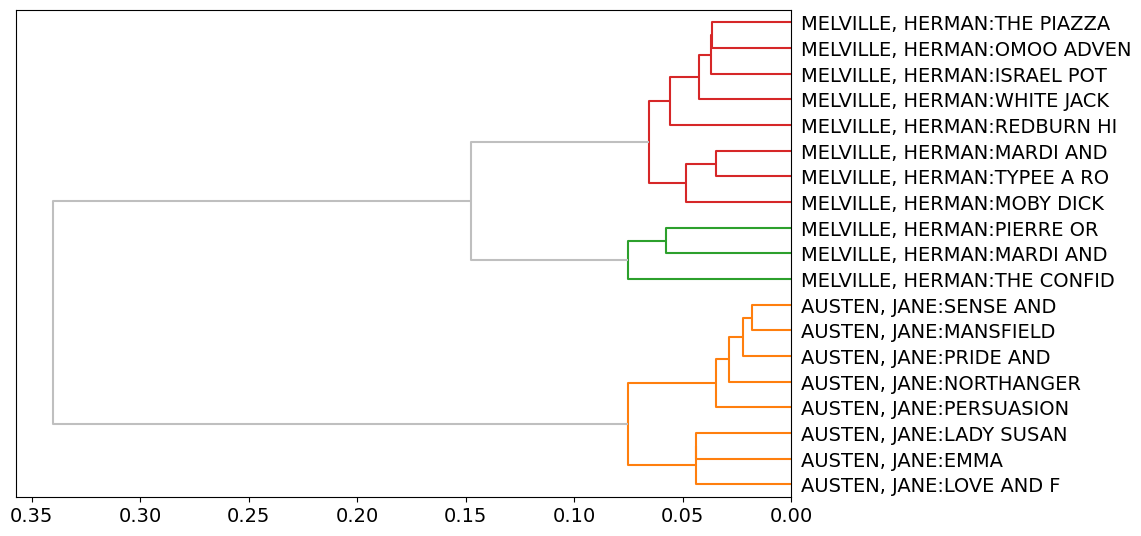

In [258]:
fig1 = HAC(BOOKS, labels=BOOKS.join(LIB.label, how='left').label.to_list())
fig1.color_thresh = .08
fig1.plot()